<a href="https://colab.research.google.com/github/tgrappoport/2dmat/blob/master/2_1_Disorder_with_kite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Kite with disorder: vacancies, Gaussian and uniform disorder








In this notebook, we will keep exploring graphene but we are interested in the effect of disorder using  *Quantum Kite*.

Let us go back to the basics, with the first two lines installing pybinding, kite and their dependencies that are not included in google colab.
Now we are removing the output as we already know what it is installing


In [ ]:
%%capture --no-display
!pip install h5py==3.8.0
!pip install -i https://test.pypi.org/simple/ pybinding quantum-kite


Now we import the libraries

In [ ]:
import numpy as np
from math import sqrt, pi
import pybinding as pb
import kite
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# seaborn setting
sns.set(style="ticks")
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})



Now let us go back to a graphene lattice and use it:

In [ ]:

from pybinding.repository import graphene
lattice = graphene.monolayer()




Now we begin with some novelties in both pybinding and Kite. Before performing the density of states calculations in Kite, let us use pybinding to visualize a vacanty. For that, we need to define a modifier that removes sites in a given radius

In [ ]:
def vacancy(position, radius):
    @pb.site_state_modifier
    def modifier(state, x, y):
        x0, y0 = position
        state[(x-x0)**2 + (y-y0)**2 < radius**2] = False
        return state
    return modifier

Whenever we define the model, we can include this modifier. Here we have a large rectangular and finite piece of graphene with a modifier that removes a single site. You can use the same structure to make big holes in graphene. But with this radius, we just remove a single site, as can be seen in the model visualization

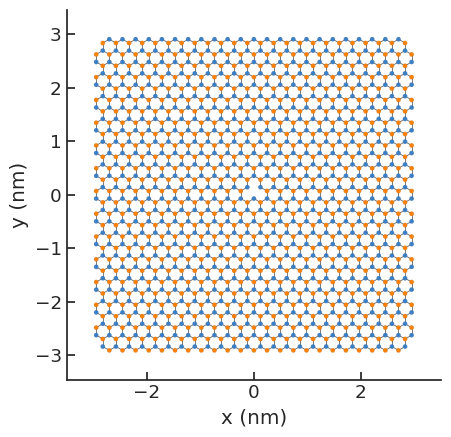

In [ ]:
model = pb.Model(
    graphene.monolayer(),
    pb.rectangle(6),
    vacancy(position=[0, 0.1], radius=0.05)
)
model.plot()

If we now use the solver to find the eigenstates and calculate the local density of states we can see that there is a pronounced contribution from the vicinity of the vacancy close to the neutrality point. The peak is not located exactly at the Dirac point because we have a finite system with zigzag edge states that also contribute with edge-states at $E=0$. We are looking at $E=0.2 eV$ to avoid seeing these contributions.

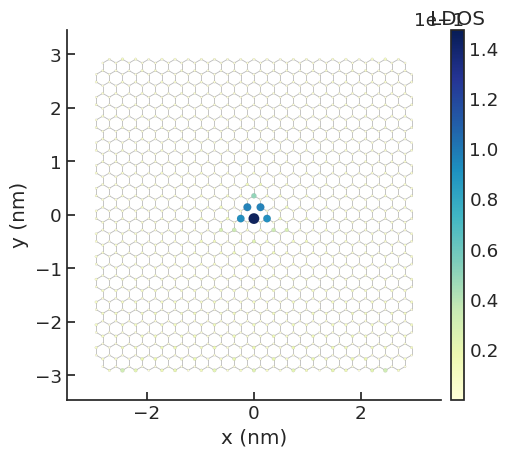

In [ ]:
solver = pb.solver.lapack(model)
ldos = solver.calc_spatial_ldos(energy=0.2, broadening=0.05)  # LDOS around 0 eV

ldos.plot(site_radius=(0.02, 0.1))
pb.pltutils.colorbar(label="LDOS")
plt.show()

Now that we have an idea of what a vacancy looks like in graphene, let us move to Kite and see the different types of disorder we can include and  how. We first use all previous definitions and we are not repeating the explanation. Check it in the previous notebook.

In [ ]:


# number of decomposition parts [nx,ny] in each direction of matrix.
# This divides the lattice into various sections, each of which is calculated in parallel
nx = ny = 2
# number of unit cells in each direction.
lx = ly = 512

    # make config object which caries info about
    # - the number of decomposition parts [nx, ny],
    # - lengths of structure [lx, ly]
    # - boundary conditions [mode,mode, ... ] with modes:
    #   . "periodic"
    #   . "open"
    #   . "twisted" -- this option needs the extra argument angles=[phi_1,..,phi_DIM] where phi_i \in [0, 2*M_PI]
    #   . "random"

# Boundary Mode
mode = "periodic"

    # - specify precision of the exported hopping and onsite data, 0 - float, 1 - double, and 2 - long double.
 # - scaling, if None it's automatic, if present select spectrum_range=[e_min, e_max]
configuration = kite.Configuration(
        divisions=[nx, ny],
        length=[lx, ly],
        boundaries=[mode, mode],
        is_complex=False,
        precision=1
)

For now, we are interested in the density of states (DOS) calculation. It is the fast calculation we can perform so it is more appropriate here, as we are not using our own computers. The same disorder configurations can be used in other types of calculations.

In [ ]:


    # specify calculation type
calculation = kite.Calculation(configuration)
calculation.dos(
        num_points=4000,
        num_moments=512,
        num_random=4,
        num_disorder=1
)


Finally we can begin with the new part, which is disorder. Kite has two different types of disorder, structural disorder (structural_disorder) that can modify the bonds as well and even remove bonds and simple disorder (disorder) that produces different types of change to the onsite energy.

Differently from what we saw on pybinding with that vacancy, here we define the type of disorder and either concentration or probability and it will be randomly distributed in you lattice.  

Structural disorder is really flexible and can be adapted to the unit cell. Here, we will not cover the more complex type of structural disorder and focus sonely on vacancies. For more information, check [Quantum Kite webpage](https://quantum-kite.com).

Let us begin with the vacancies. We can define different structural disorders and define them with

```
 kite.StructuralDisorder(lattice, concentration=0.1)
```
Add the type of disorder you want (vacancy in this case) and  finally construct a list with all the structural disorders you want. In this case below, we have vacancies in sublattice A and B with the same concentration.


In [ ]:
struc_disorder_A = kite.StructuralDisorder(lattice, concentration=0.1)
struc_disorder_A.add_vacancy('A')
struc_disorder_B = kite.StructuralDisorder(lattice, concentration=0.1)
struc_disorder_B.add_vacancy('B')
disorder_vacancy = [struc_disorder_A, struc_disorder_B]





Before performing any type of calculation, let us define other types of disorder. For onsite disorder, we use ```kite.Disorder(lattice)```. We can add a Gaussian disorder that will distribute onsite energies using a Gaussian distribution centered in its mean value witha given standard deviation std. For that, we can use the extension ```add_disorder('B', 'Gaussian', mean, std)```. Below, we have Gaussian disorders with different mean values for each sublattice. This breaks sublattice symmetry even in the case of a random distribution so one must expect a gap opening in graphene.



In [ ]:
disorder_gaussian = kite.Disorder(lattice)
disorder_gaussian.add_disorder('B', 'Gaussian', 0.2, 0.2)
disorder_gaussian.add_disorder('A', 'Gaussian', -0.2, 0.2)

disorder_uniform = kite.Disorder(lattice)
disorder_uniform.add_disorder('A', 'Uniform', 0.2, 0.6)
disorder_uniform.add_disorder('A', 'Uniform', 0.2, 0.6)



Finally, we also have a uniform distribution of onsite energies also with a mean value and a standard deviation. In the example below, the two sublattices have the same mean value and deviation.

In [ ]:
disorder_uniform = kite.Disorder(lattice)
disorder_uniform.add_disorder('A', 'Uniform', 0.2, 0.6)
disorder_uniform.add_disorder('A', 'Uniform', 0.2, 0.6)

Now we will configure three different systems that have the lattice, the configuration and calculation in common but have different disorder. This can be done by modifying a single part of the ```kite.config_system()```. Structural disorder is added with the option ```disorder_structural=name_of_disorder```, as can be seen below.



In [ ]:

%%capture --no-display
# configure the *.h5 file
output_file="vacancies-output.h5"
kite.config_system(lattice, configuration, calculation, filename=output_file, disorder_structural=disorder_vacancy)
kite.execute.kitex(output_file);
kite.execute.kitetools(output_file);






0

We can now plot the density of states and see a sizable peak at $E=0$, reflecting the existances of zero modes in graphene with vacancies.

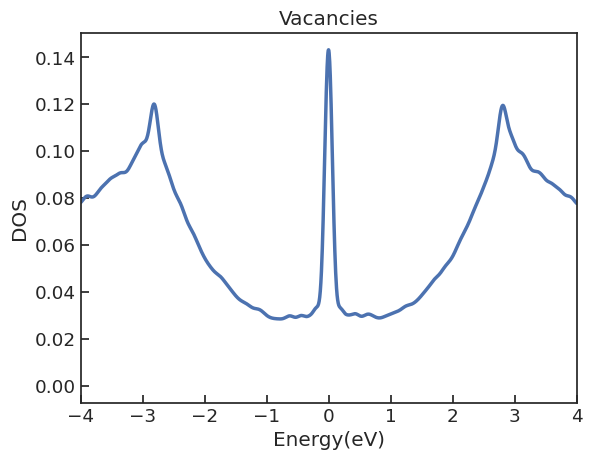

In [ ]:
dos=np.loadtxt("dos.dat",dtype=float)
plt.plot(dos[:,0],dos[:,1])
plt.xlabel("Energy(eV)")
plt.ylabel("DOS")
plt.xlim(-4,4)
plt.title("Vacancies")
plt.show()


We can repeat the procedure but now for onsite disorder, in this case, we use ```disorder=name_of_disorder``` in ```kite.config_system()```. We also use an extra option in *kite-tools* that allows to modify the DOS output. In this particular case, we only changed the name of the output file so that it is different from the previous case. Check the documentation website to see the different options.  *kite-tools* is very flexible, speacially when dealing with transport calculations. For example, it allows to obtain the conductivity for different temperatures without the need to recalculate anything in *kitex*

In [ ]:
%%capture --no-display
output_file="gaussian-output.h5"
kite.config_system(lattice, configuration, calculation, filename=output_file, disorder=disorder_gaussian)
kite.execute.kitex(output_file);
kite.execute.kitetools("gaussian-output.h5 --DOS -N dosg.dat" );

0

The new density of states presents a small energy gap, as we should expect from a system with broken A-B symmetry:

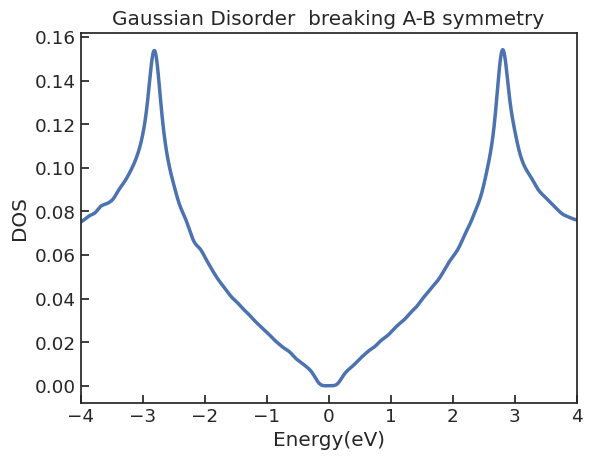

In [ ]:
dos=np.loadtxt("dosg.dat",dtype=float)
plt.plot(dos[:,0],dos[:,1])
plt.xlabel("Energy(eV)")
plt.ylabel("DOS")
plt.xlim(-4,4)
plt.title("Gaussian Disorder breaking A-B symmetry")
plt.show()

Finally, we perform the same type of calculation for a uniform distribution


In [ ]:
%%capture --no-display
output_file="uniform-output.h5"
kite.config_system(lattice, configuration, calculation, filename=output_file, disorder=disorder_uniform)
kite.execute.kitex(output_file);
kite.execute.kitetools("uniform-output.h5 --DOS -N dosu.dat ");

0

In this case, the only feature that can be seen is a small shift of Dirac point to higher energies.

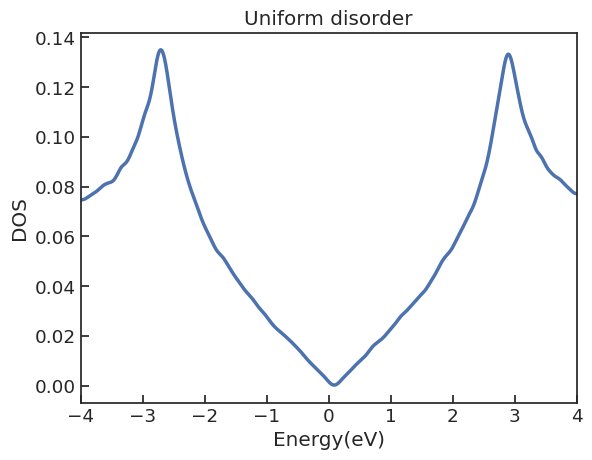

In [ ]:
dos=np.loadtxt("dosu.dat",dtype=float)
plt.plot(dos[:,0],dos[:,1])
plt.xlabel("Energy(eV)")
plt.ylabel("DOS")
plt.xlim(-4,4)
plt.title("Uniform disorder")
plt.show()